In [3]:
# %pip install pennylane
# %pip install PennyLane-qiskit

In [ ]:
# if torch.cuda.is_available():
#   device = torch.device('cuda:0')
#   print('Running on the GPU')
# else:
#   device = torch.device('cpu')
#   print('Running on the CPU')

In [4]:
import pennylane as qml
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

In [5]:
torch.manual_seed(42)
np.random.seed(42)

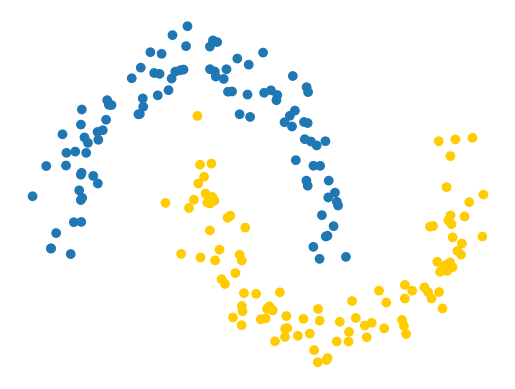

In [6]:
X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ffcc00" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

Creating quantum circuit

In [7]:
token = 'YOUR IBM TOKEN'

In [8]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)
# dev = qml.device("qiskit.aer", wires=n_qubits)
# dev = qml.device('qiskit.ibmq', wires=n_qubits, backend='ibmq_qasm_simulator', ibmqx_token=token)

In [9]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [10]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

Create hybrid model

In [11]:
qlayer_h = qml.qnn.TorchLayer(qnode, weight_shapes)

In [12]:
clayer_1_h = torch.nn.Linear(2, 2)
clayer_2_h = torch.nn.Linear(2, 2)
softmax_h = torch.nn.Softmax(dim=1)
layers_h = [clayer_1_h, qlayer_h, clayer_2_h, softmax_h]
model_h = torch.nn.Sequential(*layers_h)

In [13]:
opt_h = torch.optim.SGD(model_h.parameters(), lr=0.2)
loss_h = torch.nn.L1Loss()

In [14]:
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

epochs = 6

batch_size = 5
batches = 200 // batch_size

dataloader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

In [15]:
accuracies_h = []
avg_losses_h = []

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in dataloader:
        opt_h.zero_grad()

        loss_evaluated = loss_h(model_h(xs), ys)
        loss_evaluated.backward()

        opt_h.step()

        running_loss += loss_evaluated

    y_pred_h = model_h(X)
    predictions_h = torch.argmax(y_pred_h, axis=1).detach().numpy()
    correct_h = [1 if p == p_true else 0 for p, p_true in zip(predictions_h, y)]
    accuracy_h = sum(correct_h) / len(correct_h)
    accuracies_h.append(accuracy_h)
    avg_loss_h = running_loss / batches
    avg_losses_h.append(avg_loss_h.detach().numpy())
    print(f"Average loss over epoch {epoch + 1}: {avg_loss_h:.4f}, Accuracy = {accuracy_h:.2f}%")

Average loss over epoch 1: 0.4943, Accuracy = 0.50%
Average loss over epoch 2: 0.4226, Accuracy = 0.76%
Average loss over epoch 3: 0.2847, Accuracy = 0.81%
Average loss over epoch 4: 0.2121, Accuracy = 0.84%
Average loss over epoch 5: 0.1845, Accuracy = 0.85%
Average loss over epoch 6: 0.1666, Accuracy = 0.85%


Creating hybrid model with parallel quantum layers

In [16]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 4)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(4, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 2, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model_hp = HybridModel()

In [17]:
opt_hp = torch.optim.SGD(model_hp.parameters(), lr=0.2)
loss_hp = torch.nn.L1Loss()

In [18]:
accuracies_hp = []
avg_losses_hp = []

for epoch in range(epochs):
    running_loss = 0

    for xs, ys in dataloader:
        opt_hp.zero_grad()

        loss_evaluated = loss_hp(model_hp(xs), ys)
        loss_evaluated.backward()

        opt_hp.step()

        running_loss += loss_evaluated
    y_pred_hp = model_hp(X)
    predictions_hp = torch.argmax(y_pred_hp, axis=1).detach().numpy()
    correct_hp = [1 if p == p_true else 0 for p, p_true in zip(predictions_hp, y)]
    accuracy_hp = sum(correct_hp) / len(correct_hp)
    accuracies_hp.append(accuracy_hp)
    avg_loss_hp = running_loss / batches
    avg_losses_hp.append(avg_loss_hp.detach().numpy())
    print(f"Average loss over epoch {epoch + 1}: {avg_loss_hp:.4f}, Accuracy = {accuracy_hp:.2f}%")

Average loss over epoch 1: 0.4333, Accuracy = 0.75%
Average loss over epoch 2: 0.2811, Accuracy = 0.80%
Average loss over epoch 3: 0.2164, Accuracy = 0.81%
Average loss over epoch 4: 0.1909, Accuracy = 0.85%
Average loss over epoch 5: 0.1704, Accuracy = 0.84%
Average loss over epoch 6: 0.1639, Accuracy = 0.85%


Classical model

In [19]:
class ClassicalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 4)
        self.clayer_2 = torch.nn.Linear(4, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x = self.clayer_2(x)
        return self.softmax(x)

model_c = ClassicalModel()

In [20]:
opt_c = torch.optim.SGD(model_c.parameters(), lr=0.2)
loss_c = torch.nn.L1Loss()

In [21]:
accuracies_c = []
avg_losses_c = []

for epoch in range(epochs):
    running_loss = 0

    for xs, ys in dataloader:
        opt_c.zero_grad()

        loss_evaluated = loss_c(model_c(xs), ys)
        loss_evaluated.backward()

        opt_c.step()

        running_loss += loss_evaluated
    y_pred = model_c(X)
    predictions = torch.argmax(y_pred, axis=1).detach().numpy()
    correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
    accuracy_c = sum(correct) / len(correct)
    accuracies_c.append(accuracy_c)
    avg_loss_c = running_loss / batches
    avg_losses_c.append(avg_loss_c.detach().numpy())
    print(f"Average loss over epoch {epoch + 1}: {avg_loss_c:.4f}, Accuracy = {accuracy_c:.2f}%")

Average loss over epoch 1: 0.4054, Accuracy = 0.74%
Average loss over epoch 2: 0.2534, Accuracy = 0.81%
Average loss over epoch 3: 0.1953, Accuracy = 0.84%
Average loss over epoch 4: 0.1718, Accuracy = 0.85%
Average loss over epoch 5: 0.1606, Accuracy = 0.85%
Average loss over epoch 6: 0.1551, Accuracy = 0.87%


<ipython-input-22-910fb450ba53>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


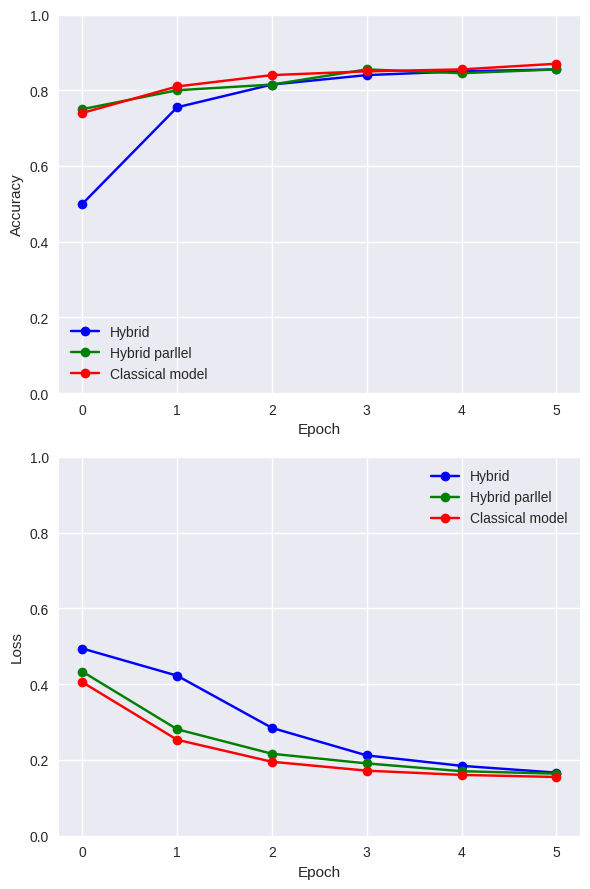

In [22]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(accuracies_h, "-ob", label="Hybrid")
ax1.plot(accuracies_hp, "-og", label="Hybrid parllel")
ax1.plot(accuracies_c, "-or", label="Classical model")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(avg_losses_h, "-ob", label="Hybrid")
ax2.plot(avg_losses_hp, "-og", label="Hybrid parllel")
ax2.plot(avg_losses_c, "-or", label="Classical model")
ax2.set_ylabel("Loss")
ax2.set_ylim([0, 1])
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()